Note ! I have created this notebook in a neat format. You can modifying the code to make it work for any of the cases (means for magnitude of accelerometer, 3D acceleration , 3D velocities etc.) The entire code is same for both HAR and ER. The only difference is in the model. ER model has one extra module. Moreover, all parameters like segmentation size, spacing between sample etc can be easily modified. Please read our thesis or paper for getting details of each parameter.
I have ran the training processing till 2 epochs only to test the entire code. Please update it to reproduce my results.  

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
!pip install numpy pandas scipy

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 256
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 16

keras version  3.4.1


In [4]:
def read_data(file_path):

    column_names = ['activity',
                    'AccMag_sub9_8']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = pd.read_csv("onlyMagWISDM11.csv")

In [5]:
df.head(5)

,activity,AccMag_sub9_8
0,Jogging,2.9
1,Jogging,2.6
2,Jogging,2.1
3,Jogging,9.0
4,Jogging,4.3


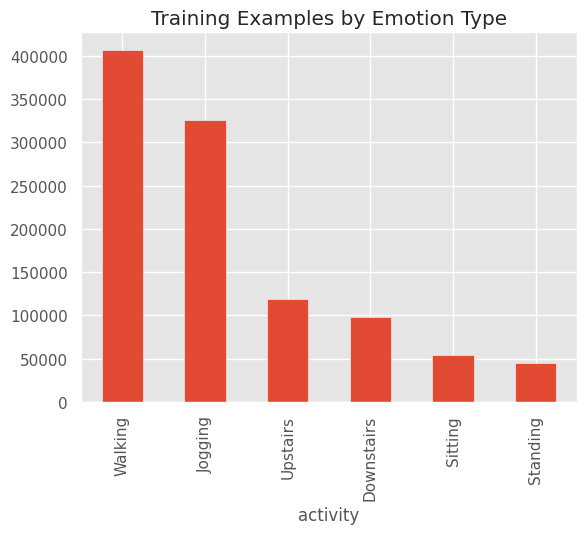

In [6]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar', title='Training Examples by Emotion Type')
plt.show()

In [7]:
df['activity'].value_counts()

,count
activity,
Walking,406775
Jogging,325975
Upstairs,118589
Downstairs,97813
Sitting,54876
Standing,44547


In [8]:
# Define column name of the label vector
LABEL = 'activity'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   activity       1048575 non-null  int64  
 1   AccMag_sub9_8  1048575 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 16.0 MB


In [10]:
df['AccMag_sub9_8']=df['AccMag_sub9_8'].astype('float')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   activity       1048575 non-null  int64  
 1   AccMag_sub9_8  1048575 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 16.0 MB


In [12]:
# Define column name of the label vector
LABEL = 'activity'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   activity       1048575 non-null  int64  
 1   AccMag_sub9_8  1048575 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 16.0 MB


In [14]:
import numpy as np
import pandas as pd
from scipy import stats

# Load your dataset into the Colab environment (if not already loaded)
# For example, if you uploaded a file named "data.csv":
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('data.csv')

def create_segments_and_labels(df, time_steps, step, label_name):
    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['AccMag_sub9_8'].values[i: i + time_steps]
        label_slice = df[label_name][i: i + time_steps]
        label_mode = stats.mode(label_slice)

        if isinstance(label_mode.mode, np.ndarray):
            label = label_mode.mode[0]
        else:
            label = label_mode.mode

        segments.append([xs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_data, y_data = create_segments_and_labels(df, TIME_PERIODS, STEP_DISTANCE, LABEL)


In [15]:
#deviding dataset into 70 % (train) and 30% test chuncks
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(45864, 256, 1) (45864,)
(19656, 256, 1) (19656,)


In [16]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
labels=list(le.classes_)
print(list(le.classes_))

[0, 1, 2, 3, 4, 5]


In [17]:
import tensorflow as tf

In [18]:
print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
print('y_train shape: ', y_train.shape)

X_train shape:  (45864, 256, 1)
45864 training samples
y_train shape:  (45864, 6)


In [19]:
print('X_test shape: ', X_test.shape)
print(X_test.shape[0], 'training samples')
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_test shape: ', y_test.shape)

X_test shape:  (19656, 256, 1)
19656 training samples
y_test shape:  (19656, 6)


#Deep Leanring Model

In [20]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [21]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [22]:
from tensorflow.keras.layers import add, Activation


In [23]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, concatenate, Flatten, Dense, Bidirectional, GRU, Multiply

In [24]:
from keras.layers import Input, Bidirectional, GRU, BatchNormalization, Conv1D, Dense, GlobalAveragePooling1D, Concatenate, Dropout, Multiply
from keras.models import Model
from keras.activations import softmax

class MultiHeadAttention:
    def __init__(self, n_heads, head_dim):
        self.n_heads = n_heads
        self.head_dim = head_dim
        self.output_dim = n_heads * head_dim

    def build(self, input_shape):
        self.k_dim = input_shape[-1] // self.n_heads
        self.q_dim = input_shape[-1] // self.n_heads
        self.v_dim = input_shape[-1] // self.n_heads

        self.query_lin = Dense(self.n_heads * self.q_dim)
        self.key_lin = Dense(self.n_heads * self.k_dim)
        self.value_lin = Dense(self.n_heads * self.v_dim)

        self.output_lin = Dense(self.output_dim)

    def apply(self, inputs):
        q, k, v = inputs

        qs = [self.query_lin(q)[:, :, i * self.q_dim: (i + 1) * self.q_dim] for i in range(self.n_heads)]
        ks = [self.key_lin(k)[:, :, i * self.k_dim: (i + 1) * self.k_dim] for i in range(self.n_heads)]
        vs = [self.value_lin(v)[:, :, i * self.v_dim: (i + 1) * self.v_dim] for i in range(self.n_heads)]

        heads = []
        for i in range(self.n_heads):
            score = softmax(tf.matmul(qs[i], ks[i], transpose_b=True) / (self.k_dim ** 0.5))
            heads.append(tf.matmul(score, vs[i]))

        concatenated = tf.concat(heads, axis=-1)
        output = self.output_lin(concatenated)

        return output

def attention_module(input_layer, hidden_units):
    attention = Dense(hidden_units, activation='tanh')(input_layer)
    attention = Dense(1, activation='softmax')(attention)
    attention = Multiply()([input_layer, attention])
    return attention

def multi_head_attention_module(input_layer, num_heads, head_hidden_units):
    heads = []
    for _ in range(num_heads):
        head = attention_module(input_layer, hidden_units=head_hidden_units)
        heads.append(head)
    return Concatenate(axis=-1)(heads)

def create_model(trainX, trainy, num_attention_heads, head_hidden_units):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_shape = (n_timesteps, n_features)

    signal_input = Input(shape=input_shape, name='data')
    gru1 = Bidirectional(GRU(64, return_sequences=True))(signal_input)
    bn = BatchNormalization()(gru1)

    # Apply multi-head attention
    bn = multi_head_attention_module(bn, num_heads=num_attention_heads, head_hidden_units=head_hidden_units)
    layer_1_a = Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_3')(bn) #with 1x1 conv
    layer_1_a = Conv1D(filters=64,  kernel_size=3, padding='same', activation='relu',name='1x3_a')(layer_1_a) # with 1x3
    layer_2_a = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_5')(bn) #with 1x1
    layer_2_a = Conv1D(64,  kernel_size=5, padding='same', activation='relu',name='1x5_a')(layer_2_a)#with 1x5
    layer_3_a = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_7')(bn) #with 1x1
    layer_3_a = Conv1D(64,  kernel_size=7, padding='same', activation='relu',name='1x7_a')(layer_3_a) #with 1x7
    layer_1_direct = Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='1x1_a_direct')(bn) #with 1x1 conv
    layer_4_b = MaxPooling1D(pool_size=1, padding='same',name='MaxPool_b_1')(bn) # pooling
    layer_4_b = Conv1D(64,  kernel_size=1, padding='same', activation='relu',name='MaxPool_1x1_b')(layer_4_b) # with 1x1
    mid_1_a = keras.layers.concatenate([layer_1_a, layer_2_a,layer_3_a,layer_1_direct,layer_4_b], axis = 2)
    drop2=Dropout(0.5)(mid_1_a)
    mid_1_a=Conv1D(filters=128,  kernel_size=1, padding='same', activation='relu',name='a_1x1_size_reduce')(drop2)
    before_flat=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu',name='before_2_1x1_size_reduce')(mid_1_a)
    globelAverage=keras.layers.GlobalAveragePooling1D(data_format='channels_last')(before_flat)
    out = Dense(n_outputs, activation='softmax', name='predictions')(globelAverage)
    rez = Model(inputs=signal_input, outputs=out)
    return rez

In [25]:
model = create_model(X_train, y_train, num_attention_heads=3, head_hidden_units=128)

In [26]:
print (model)
model.summary()

<Functional name=functional, built=True>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256, 128)       │         25,728 │ data[0][0]             │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 128)       │            512 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 128)       │         16,512 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256, 128)       │         16,512 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256, 128)       │         16,512 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 1)         │            129 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256, 1)         │            129 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256, 1)         │            129 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 128)       │              0 │ batch_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 256, 128)       │              0 │ batch_normalization[0… │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 256, 128)       │              0 │ batch_normalization[0… │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 384)       │              0 │ multiply[0][0],        │
│                           │                        │                │ multiply_1[0][0],      │
│                           │                        │                │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1x1_a_3 (Conv1D)          │ (None, 256, 64)        │         24,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1x1_a_5 (Conv1D)          │ (None, 256, 64)        │         24,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1x1_a_7 (Conv1D)          │ (None, 256, 64)        │         24,640 │ concatenate[0][0]      │
├──────────────────────

 Total params: 310,729 (1.19 MB)

 Trainable params: 310,473 (1.18 MB)

 Non-trainable params: 256 (1.00 KB)

In [27]:
inception= model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [28]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

In [29]:
verbose, epochs, batch_size = 0, 60, 120 # here are the parameters of training verbose, epoch, batchSize
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
# evaluate model

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


383/383 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - accuracy: 0.7981 - loss: 0.5075 - val_accuracy: 0.9072 - val_loss: 0.2018
Epoch 2/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.9191 - loss: 0.1855 - val_accuracy: 0.9398 - val_loss: 0.1432
Epoch 3/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.9402 - loss: 0.1411 - val_accuracy: 0.9351 - val_loss: 0.1438
Epoch 4/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.9441 - loss: 0.1235 - val_accuracy: 0.9443 - val_loss: 0.1285
Epoch 5/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9535 - loss: 0.1081 - val_accuracy: 0.9566 - val_loss: 0.0998
Epoch 6/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.9550 - loss: 0.1007 - val_accuracy: 0.9456 - val_loss: 0.1107
Epoch 7/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9579 - loss: 0.0896 - val_accuracy: 0.9527 - val_loss: 0.0949
Epoch 8/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.9570 - loss: 0.0903 - val_accurac

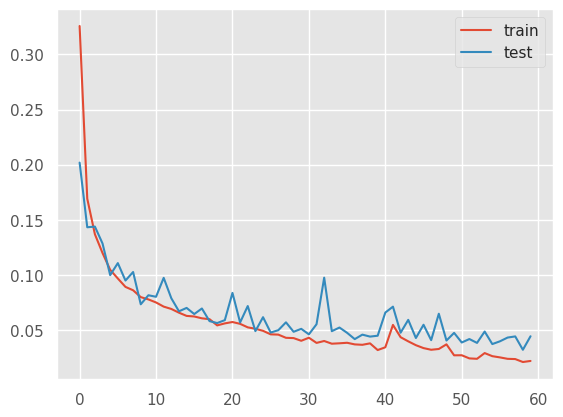

In [39]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

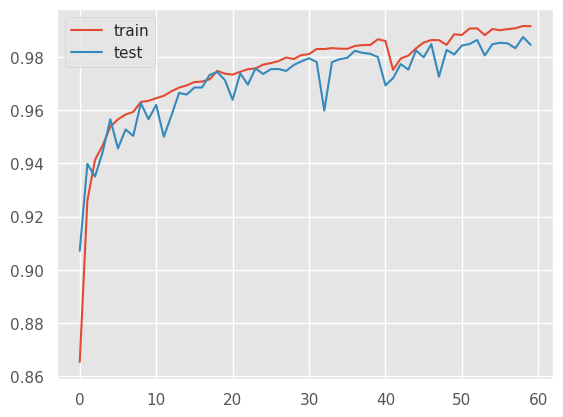

In [31]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  98.4533965587616


In [33]:
_, accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  99.13876056671143


In [34]:
model.save('AktionFocusNetz.h5')

# Confusion Matrix

In [35]:
labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [36]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred,normalize="true")
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(6, 6))
    ax = sn.heatmap(df_cm, annot=True, square=True,cmap="YlGnBu", linewidths=.2, cbar_kws={"shrink": 0.8})
    return ax

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


<Axes: >

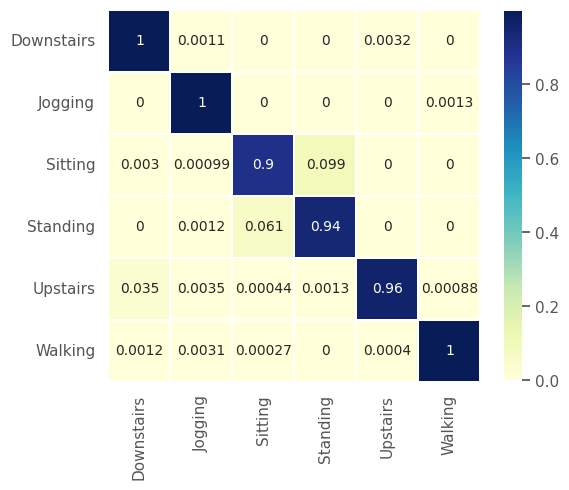

In [37]:
y_pred=model.predict(X_test)
plot_confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels)

615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step


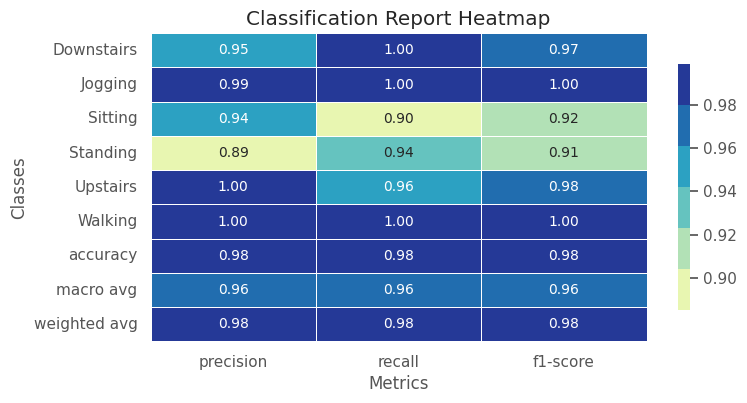

In [40]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Calculate the classification report
y_pred = model.predict(X_test)
report = classification_report(
    y_test.argmax(axis=1),
    y_pred.argmax(axis=1),
    target_names=labels,
    output_dict=True
)

# Create a DataFrame from the classification report
report_df = pd.DataFrame(report).iloc[:-1, :].T

# Define a color palette for the heatmap (yellow-blue-green)
cmap = sns.color_palette("YlGnBu")

# Create a heatmap to visualize the classification report with percentages
plt.figure(figsize=(8, 4))
ax = sns.heatmap(report_df, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Customize the plot
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Display the plot
plt.show()
